In [38]:
import warnings 
warnings.filterwarnings('ignore')

import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder


from src.data_preprocessing import sub_missing

In [2]:
PATH = '~/house-prices-prediction/data/'

In [3]:
data = pd.read_csv(PATH + 'train.csv', index_col='Id')
data.shape

(1460, 80)

# Data Cleaning

In [4]:
data = sub_missing(data)

Replace missing values in categorical columns with 'missing' and with mean in numeric columns, except for GarageYrBlt. 
GarageYrBlt, null means "no garage", so we create HasGarage binary feature where value is 1 if GarageYrBlt is present and 0 if null then substitute GarageYrBlt missing values with 0.

In [5]:
data.shape

(1460, 81)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [7]:
X = data.drop('SalePrice', axis=1)
y = data.SalePrice


In [27]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=[np.number]).columns


low_cardinality = [col for col in cat_cols if X[col].nunique() <= 10] # features with <=10 categories
high_cardinality = [col for col in cat_cols if X[col].nunique() > 10] # features with >10 categories


num_discrete = [col for col in num_cols if X[col].nunique() <= 100] # numerical features with <=100 unique values
num_discrete.append('YearBuilt') #YearBuilt has many unique values but is discrete

num_contin = [col for col in num_cols if X[col].nunique() > 100] # numerical features with > 100 unique values
num_contin.remove('YearBuilt')


# EDA

Now we will lok at features correlation

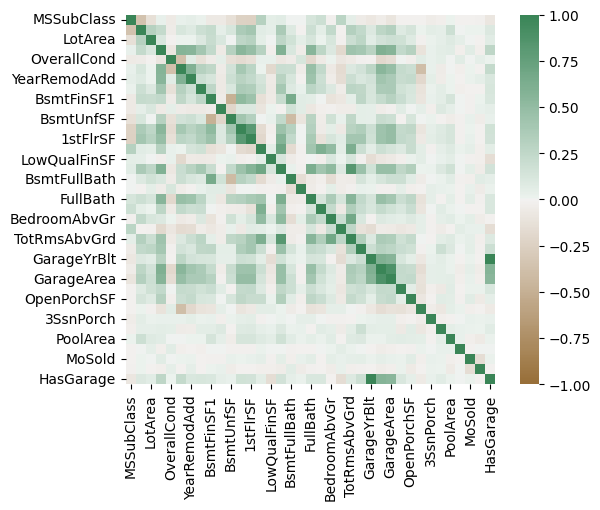

In [9]:
corr_matrix = round(data[num_cols].corr(),2)
sns.heatmap(
            corr_matrix,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True
            );

Highly correlated feature pairs are GarageArea - GarageCars (numer of cars that can be put in the garage)  and GarageYrBlt - HasGarage. It was considered to keep all of the features.

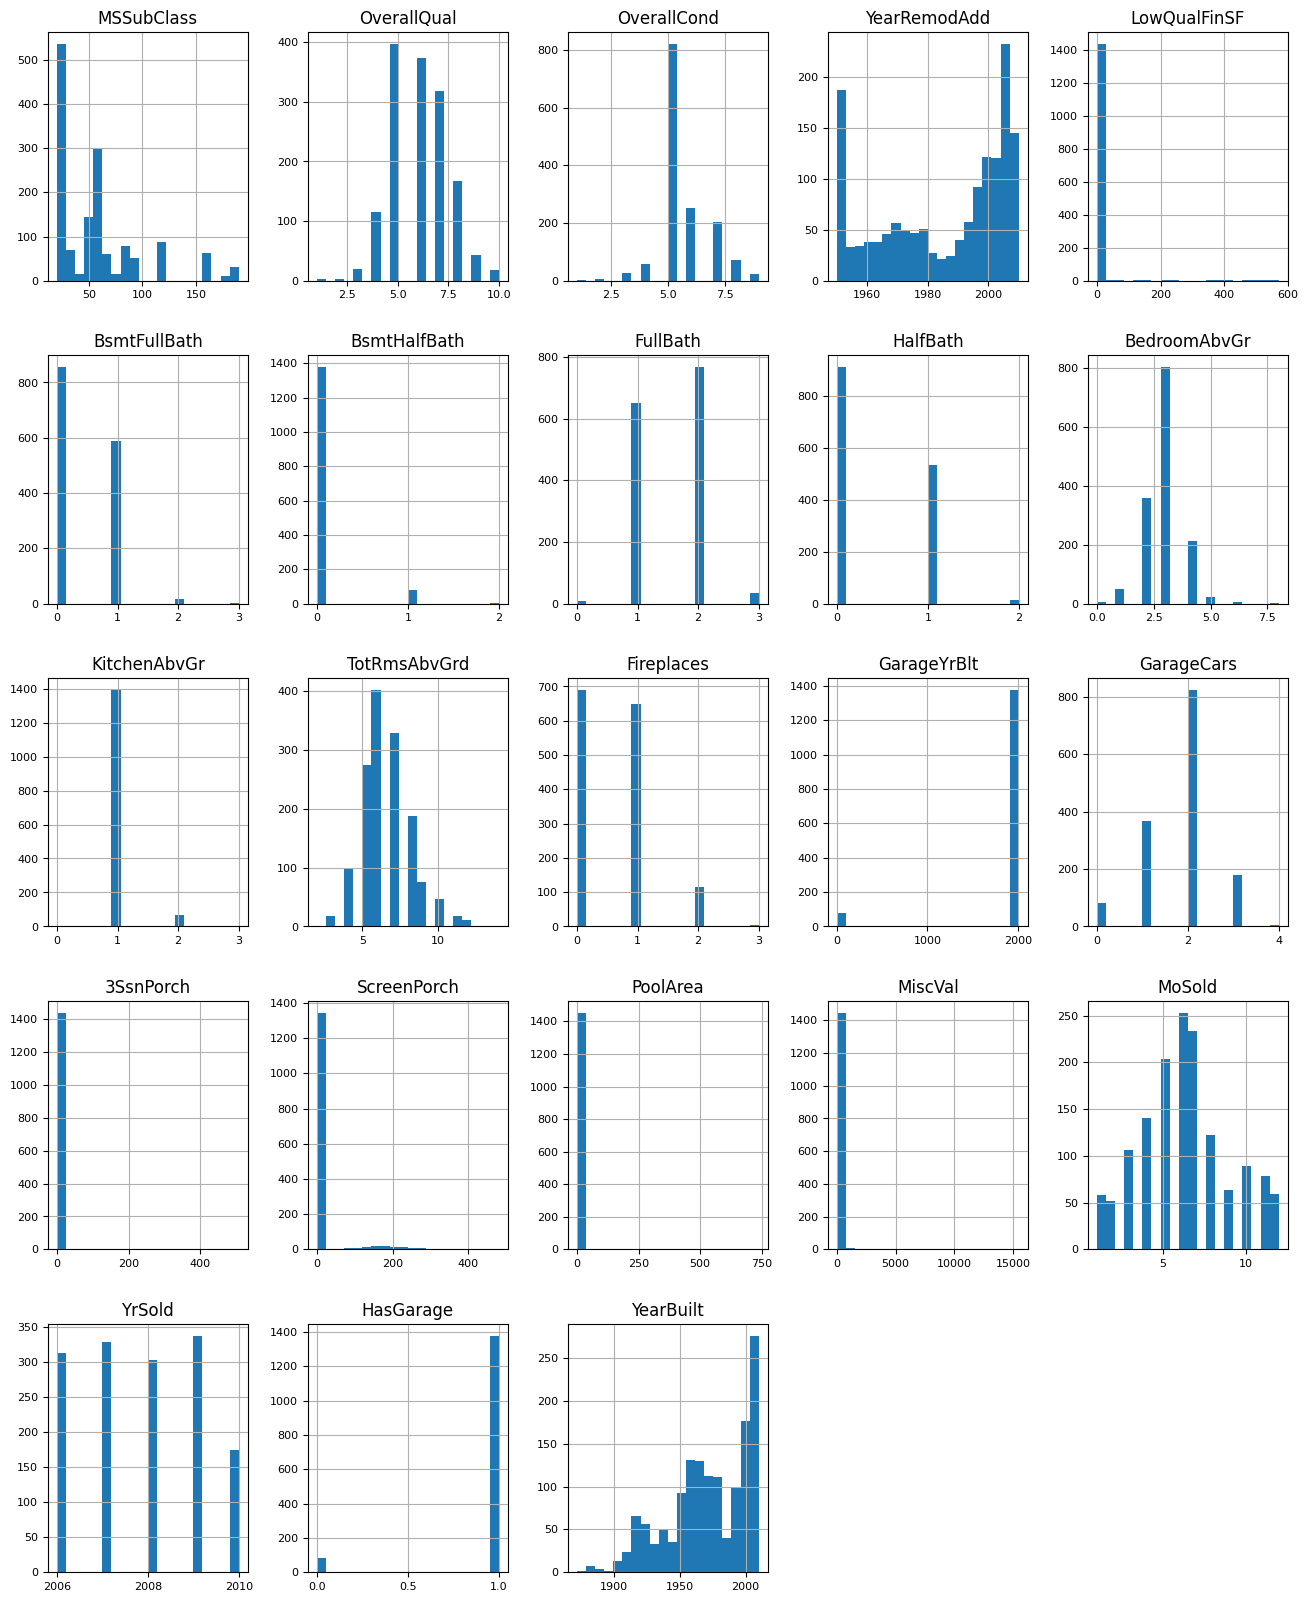

In [28]:
X[num_discrete].hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8);

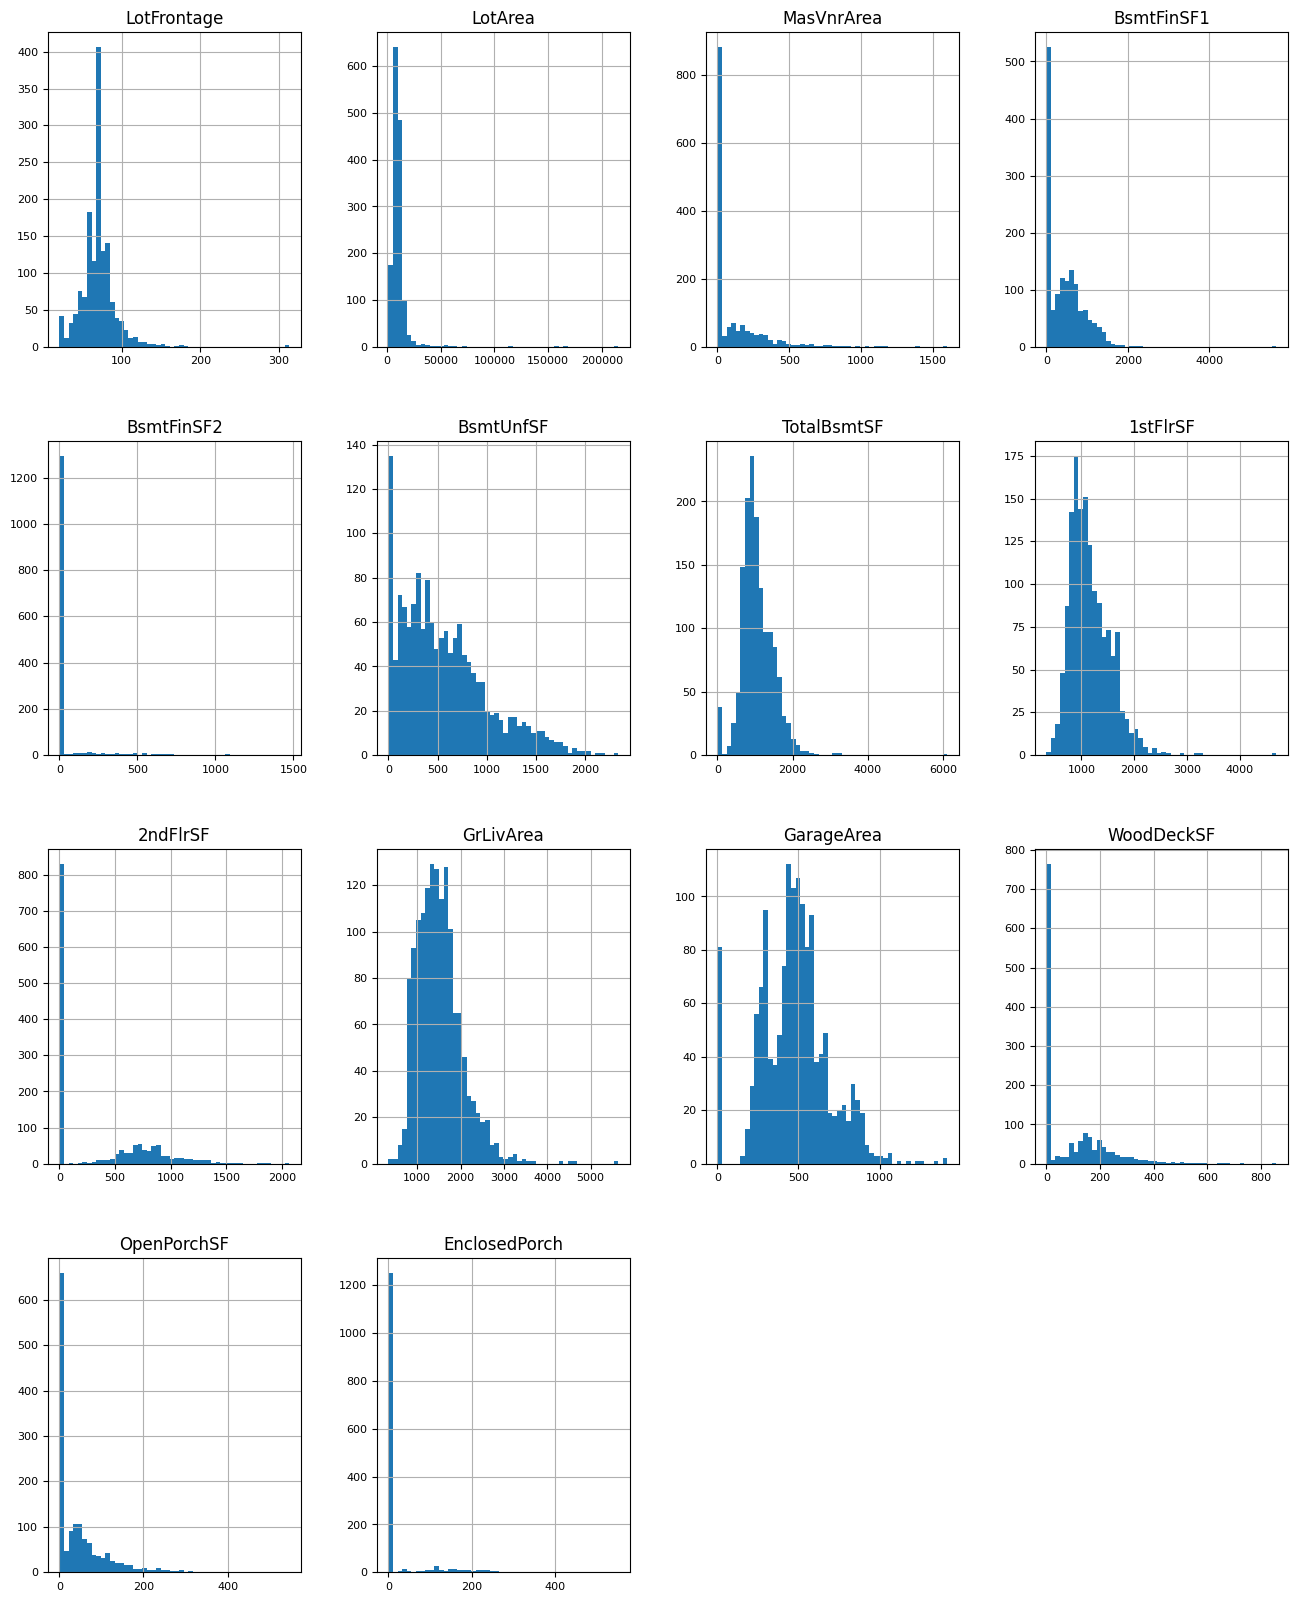

In [29]:
X[num_contin].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Fatures [] are mostly positively squewed but many has zero values so so the log(X + 1) transformation shell be used.

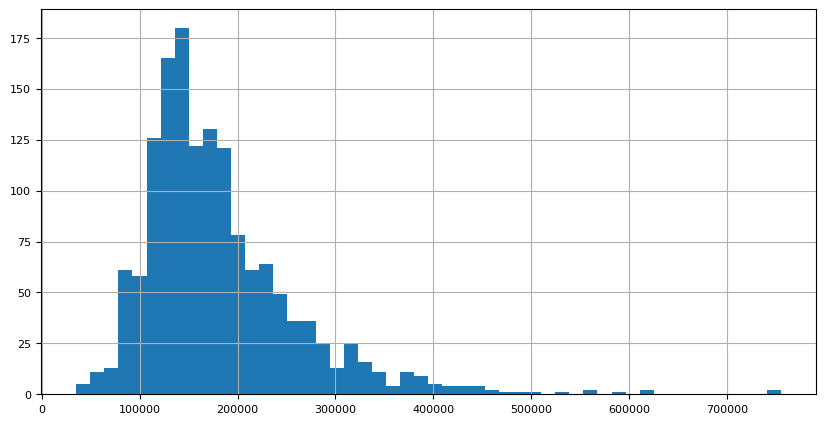

In [12]:
y.hist(figsize=(10, 5), bins=50, xlabelsize=8, ylabelsize=8);

Target values are positively sqewed so log(1 + X) transformation as well shell be used.

There are outliers in every continues numeric feature and in target vector, but they wont be an issue after log(1 + X) transformation.

# Data Preprocessing

In [40]:
preprocessor = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist'), low_cardinality),
        ('te', TargetEncoder(), high_cardinality),
        ('cont', FunctionTransformer(np.log1p, validate=False), num_contin),
        ('disc', 'passthrough', num_discrete)
    ]
)

In [41]:
y_modif = np.log1p(y)
X_modif = preprocessor.fit_transform(X, y_modif)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_modif, y_modif, test_size=0.25, random_state=42)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1095, 251), (365, 251), (1095,), (365,))